In [1]:
from matplotlib import pyplot as plt
from matplotlib import colors as colors
import numpy as np

import random

In [2]:
def read_im(fn):
    #Transform an image file into a matrice
    img = np.array(plt.imread(fn))
    return img

def convert_rgb_to_hsv(img):
    return colors.rgb_to_hsv(img)

def display_im(im):
    #Display a matrice im from an image
    plt.figure(figsize=(12, 8))
    plt.imshow(im)
    plt.show

def get_patch(i,j,h,im):
    #return a patch of size h centered on i,j from a matrice im 
    return im[(i-h//2):(i+h//2), (j-h//2):(j+h//2)]

def convert_patch_into_vectors(patch):
    pass

def noise(img,prc):
    #Noise a prc percent of the image img 
    flatimg = img.reshape(-1, img.shape[-1])
   # print(flatimg.shape)
    
    randnoise = random.sample(range(0, len(flatimg)), int(len(flatimg)*prc))
    for i in randnoise:
        flatimg[i] = np.array([0,0,0])
    return flatimg.reshape([img.shape[0], img.shape[1], 3])      
    

def delete_rect(img,i,j,height, width):
    #Delete a rectangle of an image centered on i, j and size height and width
    pass

def generate_patch():
    pass

def get_dictionnary():
    pass

taille de l'image :  (768, 1024, 3)


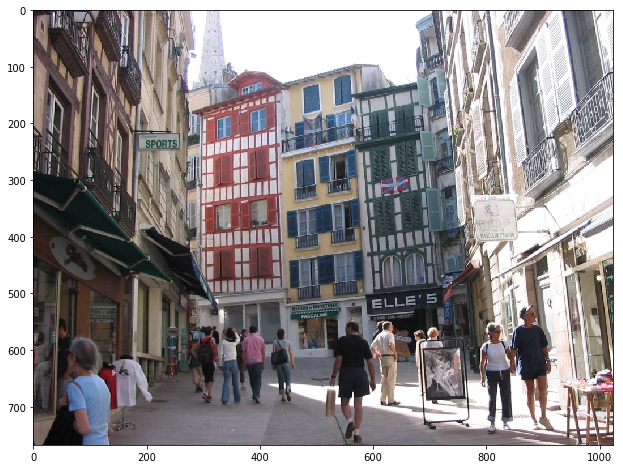

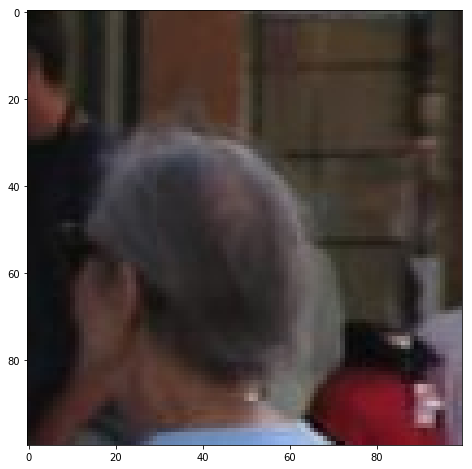

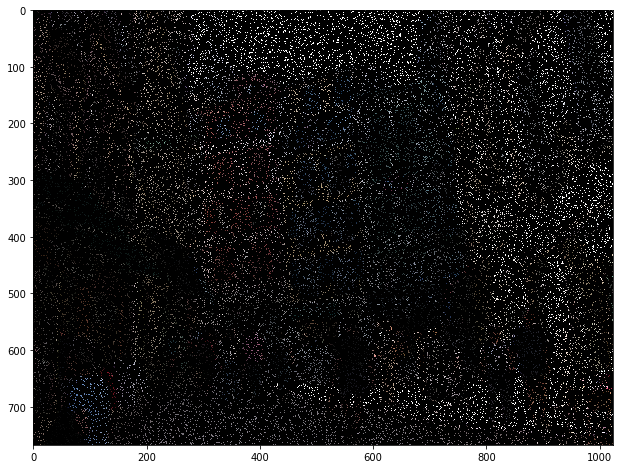

In [3]:
img_matrice = read_im("Data/imgdataset/1.jpg")

print("taille de l'image : ", img_matrice.shape)

display_im(img_matrice)

display_im(get_patch(600, 100, 100, img_matrice))

noisy_image = noise(img_matrice, 0.9)

display_im(noisy_image)
